In [1]:
SNT_SCORE_DATA_PATH =  r'D:\Projects\Quantum Bits\News-Impact-on-Stock-Prices-\Project_data\output\sen_score_data.csv'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score , confusion_matrix , classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch




c:\Users\DELL\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv(SNT_SCORE_DATA_PATH)

In [6]:
data =  df.copy()

In [7]:
data.head(1)

,Ticker,Date,Headline,Close,Price_Change,Label,Processed_Headline,Sentiment
0,AAPL,2024-08-28,apple becomes indias largest bluecollar job cr...,226.490005,-1.539993,-1,apple becomes india largest bluecollar job cre...,0.087822


# 1-Preprocessing

We don't need Ticker and Date for our text classification task so we will remove them

In [8]:
data = data.drop(['Ticker', 'Date' , 'Headline'] , axis= 1 ) 

In [9]:
data = data[['Processed_Headline','Sentiment' , 'Close', 'Price_Change', 'Label']]

In [10]:
data.isna().sum()

Processed_Headline    0
Sentiment             0
Close                 0
Price_Change          0
Label                 0
dtype: int64

In [11]:
data[data.duplicated()]

,Processed_Headline,Sentiment,Close,Price_Change,Label


In [12]:
data.head(1)

,Processed_Headline,Sentiment,Close,Price_Change,Label
0,apple becomes india largest bluecollar job cre...,0.087822,226.490005,-1.539993,-1


In [13]:
data['Label'].value_counts()

Label
 1    63
-1    50
Name: count, dtype: int64

In [15]:
data.head(1)

,Processed_Headline,Sentiment,Close,Price_Change,Label
0,apple becomes india largest bluecollar job cre...,0.087822,226.490005,-1.539993,-1


In [16]:
X = data.drop('Label' , axis=1)
y = data['Label']

### Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
y_train.value_counts() , y_test.value_counts()

(Label
  1    51
 -1    39
 Name: count, dtype: int64,
 Label
  1    12
 -1    11
 Name: count, dtype: int64)

### TFIDF

In [19]:
tfidf = TfidfVectorizer(max_features=5000 , ngram_range=(1,2))  # Adjust `max_features` and `ngram_range` as needed

# Fit and transform the training data, transform the testing data
X_train_tfidf = tfidf.fit_transform(X_train['Processed_Headline'])
X_test_tfidf = tfidf.transform(X_test['Processed_Headline'])

In [20]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8645 stored elements and shape (90, 5000)>

In [21]:
# Convert to DataFrame for easier merging
tfidf_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
# tfidf_train_df

# Modeling

In [35]:
Comparing_modes_results = []

## Base line model

In [36]:
# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(tfidf_train_df, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_tfidf)


c:\Users\DELL\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [37]:
# Print the classification report
print(classification_report(y_test, y_pred))

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1_score = f1_score(y_test, y_pred, average='weighted')


              precision    recall  f1-score   support

          -1       0.50      0.09      0.15        11
           1       0.52      0.92      0.67        12

    accuracy                           0.52        23
   macro avg       0.51      0.50      0.41        23
weighted avg       0.51      0.52      0.42        23

Accuracy: 0.5217391304347826


In [38]:
Comparing_modes_results.append({
    'Model': 'BaseLine_Log_Regression',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1_score
})

## cross-validation 

In [22]:


# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

# Define a StratifiedKFold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store results
results = []

# Define custom scorers for precision, recall, and F1-score
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Measure the start time
    start_time = time.time()
    
    # Perform cross-validation for training data
    train_accuracies = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring=scorers['accuracy'])
    train_precisions = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring=scorers['precision'])
    train_recalls = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring=scorers['recall'])
    train_f1_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring=scorers['f1_score'])
    
    # Fit model on training data and evaluate on test data
    model.fit(X_train_tfidf, y_train)
    y_test_pred = model.predict(X_test_tfidf)
    
    # Measure the end time
    end_time = time.time()
    training_time = end_time - start_time
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store the results
    results.append({
        'Model': model_name,
        'Train Accuracy': train_accuracies.mean(),
        'Train Precision': train_precisions.mean(),
        'Train Recall': train_recalls.mean(),
        'Train F1-Score': train_f1_scores.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1-Score': test_f1_score,
        'Training Time (s)': training_time
    })

# Convert results to a DataFrame and sort by Test Accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

results_df


Training Naive Bayes...
Training SVM...


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Training Random Forest...


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training KNN...


,Model,Train Accuracy,Train Precision,Train Recall,Train F1-Score,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Training Time (s)
3,KNN,0.544444,0.538737,0.544444,0.531442,0.695652,0.706522,0.695652,0.688533,0.084939
2,Random Forest,0.577778,0.606409,0.588889,0.482390,0.652174,0.667702,0.652174,0.638371,3.982049
0,Naive Bayes,0.588889,0.551861,0.588889,0.470901,0.565217,0.605797,0.565217,0.495342,0.096642
1,SVM,0.588889,0.506645,0.588889,0.455566,0.521739,0.272212,0.521739,0.357764,0.167830


I will choose Random Forest because:


1. **Stability**: Random Forest is generally more stable because it is an ensemble method, meaning it builds multiple decision trees and averages their results. This reduces the variance and makes the model less sensitive to overfitting, especially compared to KNN, which might be more sensitive to the specific training data.

2. **Balanced Performance**: While KNN has a slightly higher test accuracy, Random Forest shows a more balanced performance across the metrics (accuracy, precision, recall, F1-score) both in training and testing phases. This balance indicates that the model is reliable across different evaluation criteria, not just accuracy.

3. **Generalization**: Random Forest has slightly lower test accuracy compared to KNN, but its better performance on training data and overall stability suggests it might generalize better across different datasets, especially if you expand or change your dataset.

4. **Robustness**: Random Forest is less likely to be impacted by noisy data or outliers, which can be a significant advantage in real-world applications where data quality may vary.




## Selected model : Random Forest

### hyperparameter tuning

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for splitting
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [109]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.6444444444444445


### Evaluate the best model on the test data

In [118]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [39]:

best_rf_model = RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=300, random_state=42 )

best_rf_model.fit(X_train_tfidf, y_train)

y_pred = best_rf_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.6086956521739131
Classification Report:
               precision    recall  f1-score   support

          -1       0.67      0.36      0.47        11
           1       0.59      0.83      0.69        12

    accuracy                           0.61        23
   macro avg       0.63      0.60      0.58        23
weighted avg       0.63      0.61      0.58        23



In [40]:
y_train.value_counts() , y_test.value_counts()

(Label
  1    51
 -1    39
 Name: count, dtype: int64,
 Label
  1    12
 -1    11
 Name: count, dtype: int64)

In [41]:
confusion_matrix(y_test, y_pred)

array([[ 4,  7],
       [ 2, 10]], dtype=int64)

In [42]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1_score = f1_score(y_test, y_pred, average='weighted')

Comparing_modes_results.append({
    'Model': 'RandomForest',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1_score
})

There is a problem in -1 class we can solve this with Resampling Techniques or Adjusting Class Weights or return to data scraping phase and try to collect more -1 classes

# Try Deep Learning

I expect the deep learning will not work well because the data is so small but let's try:

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

# Convert the 'Processed_Headline' to sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Processed_Headline'])  # Fit on training data

X_train_seq = tokenizer.texts_to_sequences(X_train['Processed_Headline'])
X_test_seq = tokenizer.texts_to_sequences(X_test['Processed_Headline'])

# Pad sequences to ensure uniform length
max_sequence_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Define the vocabulary size and embedding dimensions
vocab_size = len(tokenizer.word_index) + 1  # +1 for the padding token
embedding_dim = 100

In [74]:
# RNN Model with Embedding Layer
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_padded, y_train, epochs=20, batch_size=16, validation_data=(X_test_padded, y_test))

Epoch 1/20


c:\Users\DELL\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.1324 - loss: 0.6580 - val_accuracy: 0.0000e+00 - val_loss: 0.2747
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.0000e+00 - loss: 0.2157 - val_accuracy: 0.2174 - val_loss: 0.6119
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0503 - loss: 0.2017 - val_accuracy: 0.0000e+00 - val_loss: 0.2156
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0419 - loss: -0.3942 - val_accuracy: 0.4783 - val_loss: 0.7742
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4699 - loss: -0.7833 - val_accuracy: 0.0000e+00 - val_loss: 0.0967
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5001 - loss: -1.5627 - val_accuracy: 0.0000e+00 - val_loss: 0.2100
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4285 - loss: -1.7248 - val_accuracy: 0.0435 - val_loss: 0.0864
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5269 - loss: -2.4695 - val_accuracy: 0.0000e+00 

In [75]:
# Evaluate RNN
rnn_pred = (rnn_model.predict(X_test_padded) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


In [76]:
print(f"RNN Accuracy: {accuracy_score(y_test, rnn_pred)}")
print(f"RNN Precision: {precision_score(y_test, rnn_pred, average='macro')}")
print(f"RNN Recall: {recall_score(y_test, rnn_pred, average='macro')}")
print(f"RNN F1-Score: {f1_score(y_test, rnn_pred, average='macro')}")

RNN Accuracy: 0.043478260869565216
RNN Precision: 0.3333333333333333
RNN Recall: 0.027777777777777776
RNN F1-Score: 0.05128205128205129


c:\Users\DELL\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
test_accuracy = accuracy_score(y_test, rnn_pred)
test_precision = precision_score(y_test, rnn_pred, average='weighted')
test_recall = recall_score(y_test, rnn_pred, average='weighted')
test_f1_score = f1_score(y_test, rnn_pred, average='weighted')

Comparing_modes_results.append({
    'Model': 'RNN',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1_score
})

c:\Users\DELL\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As I expected the RNN doesn't perform well, finally let's try Transformers

# Try transformers

In [79]:

model_path = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


c:\Users\DELL\miniconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [80]:
s = ['I it very good ' , 'it is very very bad' , 'can i play here?']

In [81]:
# Tokenize the text data
encoded_inputs = tokenizer(X['Processed_Headline'].tolist(), padding=True, truncation=True, return_tensors="pt")


In [82]:
encoded_inputs

{'input_ids': tensor([[    0, 27326,  3374,  ...,     1,     1,     1],
        [    0,  1588,   625,  ...,     1,     1,     1],
        [    0,  2802, 25401,  ...,     1,     1,     1],
        ...,
        [    0,   879,  8726,  ...,     1,     1,     1],
        [    0,   698,   275,  ...,     1,     1,     1],
        [    0, 12782,  2560,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [83]:
# Perform inference
with torch.no_grad():
    outputs = model(**encoded_inputs)
    
# Apply softmax to get probabilities
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Convert to numpy array
probs = probs.numpy()

# Extract predicted labels (0 = negative, 1 = positive)
predicted_labels = probs.argmax(axis=1)


In [84]:
predicted_labels

array([2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2,
       0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2,
       2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 0, 2], dtype=int64)

In [85]:
# Compare predicted labels with actual labels
df['Predicted_Label'] = predicted_labels
df['Predicted_Probability'] = probs.max(axis=1)

df[['Processed_Headline', 'Label', 'Predicted_Label', 'Predicted_Probability']]


,Processed_Headline,Label,Predicted_Label,Predicted_Probability
0,apple becomes india largest bluecollar job cre...,-1,2,0.999535
1,ipad mini 7 rumored september launch current m...,1,0,0.983273
2,vertex pharmaceutical inc vrtx jim cramers got...,-1,2,0.998162
3,broadcom inc avgo tech stock monitor amid mark...,1,0,0.993362
4,jim cramer advanced micro device inc amd zt sy...,1,2,0.999369
...,...,...,...,...
108,final trade lennar oracle seagate exclusive ch...,1,1,0.999789
109,hmgs u ev sale rank second behind tesla top 10...,-1,2,0.999404
110,unrealized gain safe bidenharris tax proposal ...,-1,2,0.998809
111,10 best car subscription service usa elon musk...,1,0,0.969371


In [86]:
df['Predicted_Label'] = df['Predicted_Label'].map(
    {
        2: 1,
        1: 1,
        0: -1
    }
)

In [87]:
df['Label'].value_counts()


Label
 1    63
-1    50
Name: count, dtype: int64

In [88]:
df['Predicted_Label'].value_counts()

Predicted_Label
 1    92
-1    21
Name: count, dtype: int64

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(df['Label'], df['Predicted_Label'])
precision = precision_score(df['Label'], df['Predicted_Label'])
recall = recall_score(df['Label'], df['Predicted_Label'])
f1 = f1_score(df['Label'], df['Predicted_Label'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(df['Label'], df['Predicted_Label']))


Accuracy: 0.5841
Precision: 0.5870
Recall: 0.8571
F1-Score: 0.6968
              precision    recall  f1-score   support

          -1       0.57      0.24      0.34        50
           1       0.59      0.86      0.70        63

    accuracy                           0.58       113
   macro avg       0.58      0.55      0.52       113
weighted avg       0.58      0.58      0.54       113



In [90]:
Comparing_modes_results.append({
    'Model': 'distilroberta',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Comparing_modes performance

In [96]:
models_results = pd.DataFrame( Comparing_modes_results)

In [97]:
models_results

,Model,Accuracy,Precision,Recall,F1-Score
0,BaseLine_Log_Regression,0.521739,0.512422,0.521739,0.421405
1,RandomForest,0.608696,0.625746,0.608696,0.584884
2,RNN,0.043478,0.521739,0.043478,0.080268
3,distilroberta,0.584071,0.586957,0.857143,0.696774


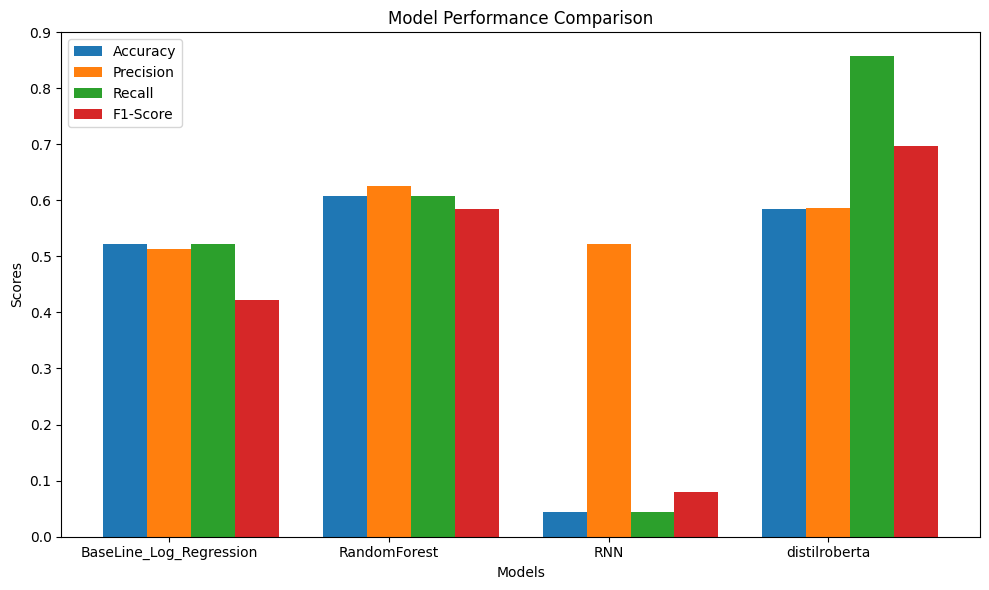

In [99]:
# Plotting
import numpy as np

bar_width = 0.2
index = np.arange(len(models_results['Model']))

plt.figure(figsize=(10, 6))
plt.bar(index, models_results['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, models_results['Precision'], bar_width, label='Precision')
plt.bar(index + 2 * bar_width, models_results['Recall'], bar_width, label='Recall')
plt.bar(index + 3 * bar_width, models_results['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width, models_results['Model'])
plt.legend()

plt.tight_layout()
plt.show()

 

### Conclusion:
- **RandomForest** and **distilroberta** are the top performers, with distilroberta being preferable when the priority is Recall (high recall).

- As i expect The **RNN** model is not suitable in this case, because the data is so small.

- The baseline model, **Logistic Regression**, serves as a good reference point but is outperformed by more sophisticated models.